In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import open3d as o3d
from open3d.visualization import draw
import os

%matplotlib inline

## Set Functions

In [2]:
def calibrate_cam(filename):
    img = cv2.imread(filename, 
                 cv2.IMREAD_GRAYSCALE)

    criteria = (cv2.TERM_CRITERIA_EPS + 
                    cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    objp = np.zeros((5*5,3), np.float32)
    objp[:,:2] = np.mgrid[0:5,0:5].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = [] 

    ret, corners = cv2.findChessboardCorners(img, (5,5), None)
    ret

    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(img,corners,(11,11),
                                    (-1,-1),criteria)
        imgpoints.append(corners2)



    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints, 
                                                       img.shape[::-1],None,None)
    
    return  mtx, dist
    
def get_pnp(mtx, dist, world, imagept):
    success, rvecs, tvecs = cv2.solvePnP(world, 
                                     imagept, 
                                     mtx, 
                                     dist, 
                            flags=cv2.SOLVEPNP_EPNP)
    return rvecs, tvecs


def project_test(mtx, dist, rvecs, tvecs, i):
    nyp4_2d, jacobian = cv2.projectPoints(nyp4, 
                                          rvecs, 
                                          tvecs,
                                          mtx, 
                                          dist)
 
    plt.imshow(thermal, cmap = 'gray')
    plt.plot( int(nyp4_2d[0][0][0]),int(nyp4_2d[0][0][1]), marker='o', color="red")
    plt.plot( int(nyp4_2d[1][0][0]),int(nyp4_2d[1][0][1]), marker='o', color="blue")
    plt.plot( int(nyp4_2d[2][0][0]),int(nyp4_2d[2][0][1]), marker='o', color="green")
    plt.axis('off')


In [7]:
def linear_map(xmin, xmax, Tmin, Tmax):
    """
    Map image intensity to temperatures.
    """

    return lambda x: Tmin + (x - xmin) / (xmax - xmin) * (Tmax - Tmin)

dT = 273.15
xmin = 0
xmax = 255
Tmin = 294 - dT
Tmax = 340 - dT

## Load INO Image and points

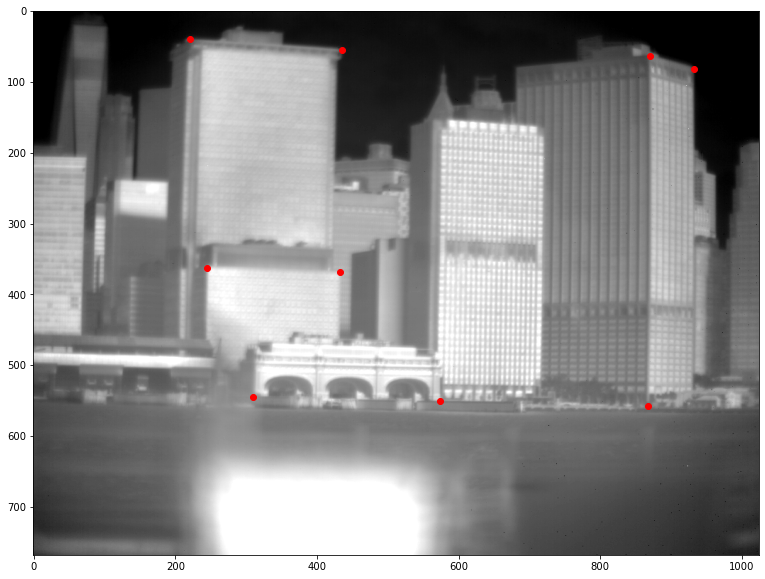

In [3]:
plt.figure(figsize=(13,14))
thermal = cv2.imread('GI_2021-10-18_12-04-48.0479.bmp', 
                     cv2.IMREAD_GRAYSCALE)

thermal_pts = np.array([
    (220,40), 
    (435,55), 
    (245,363), 
    (432,368),    
    (310,545),
    (573,550),
#     (74,207),
#     (563,153),
# #     (720,164),
    (870,64),
    (932,82),
    (867,558),
], dtype=np.float32)



plt.imshow(thermal, cmap = 'gray')
for i in thermal_pts:
    plt.plot(i[0],i[1], marker='o', color="red") #NYP1

In [4]:
world = np.array([
    (980789.1, 195006.7, 644),
    (981061.2, 195066.0, 644),
    (980827.3, 194931.9, 239),
    (981058.9, 194983.6, 239),
    (980880.0, 194552.6, 6),
    (981178.9, 194643.3, 6),
#     (980610.8, 195222.6, 314),
#     (981241.0, 195088.5, 522),
    (981698.8, 195245.1, 690),
    (981814.2, 195347.4, 690),
     (981698.8, 195245.1, 8),
])


### Apply functions

In [5]:
h,  w = thermal.shape[:2]

# dist= np.zeros((4,1))

mtx, dist = calibrate_cam('GI_2021-12-01_13-35-15.0700.bmp')

new_mtx,roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

rvecs, tvecs = get_pnp(mtx, dist, world, thermal_pts)

# project_test(mtx, dist, rvecs, tvecs, i)

### Tranform to Temp (c)

In [8]:
temp = linear_map(xmin, xmax, Tmin, Tmax)(thermal)

## Project Points

In [9]:
xyz = np.genfromtxt('gi_view_pointcloud.csv', delimiter=',')[1:]

In [9]:
xyz.shape

(40534345, 3)

In [10]:
dist= np.zeros((4,1))
pointx = []
valx = []
for i in range((xyz.shape[0])):
    pcx,_ = cv2.projectPoints(xyz[i],rvecs,tvecs,new_mtx,dist)
    try: 
        val = temp[int(pcx[0][0][1]), int(pcx[0][0][0])]
        pointx.append([xyz[i][0],xyz[i][1],xyz[i][2]])
        valx.append(val)
    except:
        pass

In [11]:
np.asarray(pointx).shape

(36407555, 3)

In [ ]:
## use for coloring in open3D

densities = np.asarray(valx)
density_colors = plt.get_cmap('plasma')(
    (densities - densities.min()) / (densities.max() - densities.min()))
density_colors = density_colors[:, :3]

# density_colors

In [ ]:
# np.savetxt("xyz.csv", np.asarray(pointx), delimiter=",")
# np.savetxt("thermal_temp.csv",np.asarray(valx) , delimiter=",")

In [ ]:
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(np.asarray(pointx))
# pcd.colors = o3d.utility.Vector3dVector(density_colors)
# draw(pcd)

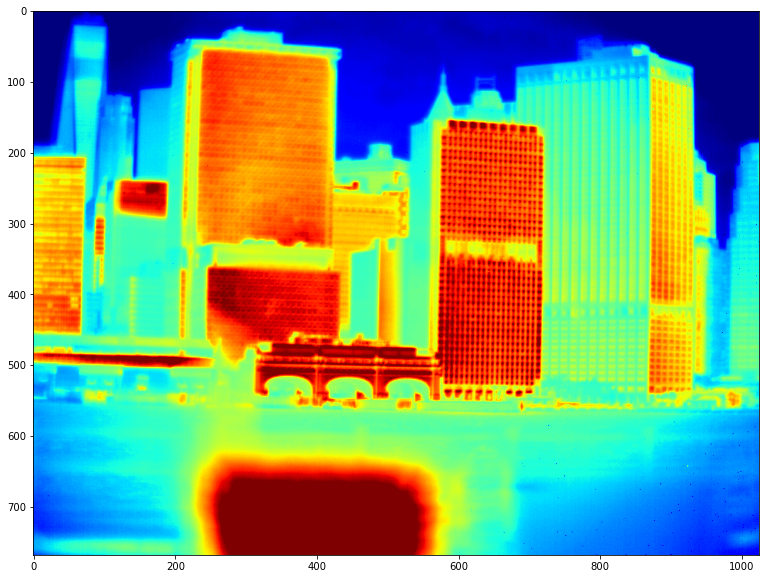

In [15]:
plt.figure(figsize=(13,14))
plt.imshow(thermal, cmap = 'jet')